In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier

In [2]:
# Load & Preprocess Data
df = pd.read_csv("creditcard.csv")  

print("Shape:", df.shape)
print(df['Class'].value_counts(normalize=True))

X = df.drop("Class", axis=1)
y = df["Class"]

Shape: (284807, 31)
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [3]:
# scale Time & Amount only (others already PCA transformed V1-V28)
scaler = StandardScaler()
X[["Time", "Amount"]] = scaler.fit_transform(X[["Time", "Amount"]])

# train/test split with stratification (preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
# B. Base Models
log_clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
xgb_clf = XGBClassifier(
    n_estimators=300, max_depth=4, learning_rate=0.1, subsample=0.8,
    colsample_bytree=0.8, eval_metric="logloss", scale_pos_weight=(y==0).sum()/(y==1).sum(),
    random_state=42
)

In [5]:
# Voting Classifier 
voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rf_clf), ("xgb", xgb_clf)],
    voting="soft"
)

In [6]:
# Stacking Classifier 
stacking_clf = StackingClassifier(
    estimators=[("rf", rf_clf), ("xgb", xgb_clf)],
    final_estimator=LogisticRegression(max_iter=1000, class_weight="balanced"),
    cv=5, n_jobs=-1
)

In [7]:
# E. Train & Evaluate
models = {
    "Logistic Regression": log_clf,
    "Random Forest": rf_clf,
    "XGBoost": xgb_clf,
    "Voting (Hybrid)": voting_clf,
    "Stacking (Hybrid)": stacking_clf
}


===== Training: Logistic Regression =====
              precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0609    0.9184    0.1141        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5509     56962
weighted avg     0.9982    0.9755    0.9861     56962

ROC-AUC: 0.9721669425367221


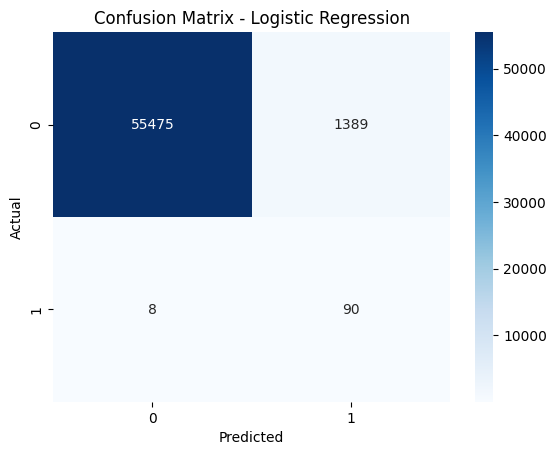


===== Training: Random Forest =====
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9605    0.7449    0.8391        98

    accuracy                         0.9995     56962
   macro avg     0.9800    0.8724    0.9194     56962
weighted avg     0.9995    0.9995    0.9995     56962

ROC-AUC: 0.952908497036969


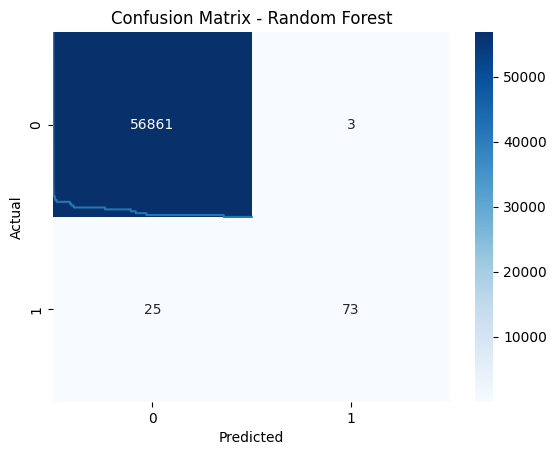


===== Training: XGBoost =====
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8137    0.8469    0.8300        98

    accuracy                         0.9994     56962
   macro avg     0.9067    0.9233    0.9149     56962
weighted avg     0.9994    0.9994    0.9994     56962

ROC-AUC: 0.9815286096149208


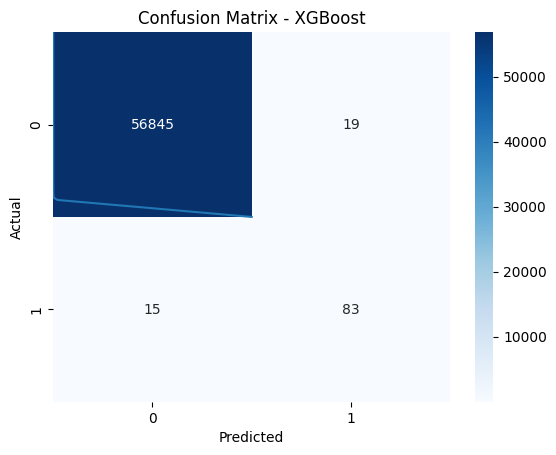


===== Training: Voting (Hybrid) =====
              precision    recall  f1-score   support

           0     0.9998    0.9996    0.9997     56864
           1     0.7944    0.8673    0.8293        98

    accuracy                         0.9994     56962
   macro avg     0.8971    0.9335    0.9145     56962
weighted avg     0.9994    0.9994    0.9994     56962

ROC-AUC: 0.9723166911671816


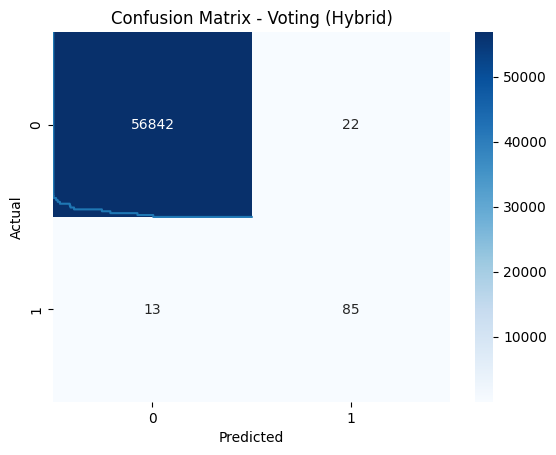


===== Training: Stacking (Hybrid) =====
              precision    recall  f1-score   support

           0     0.9998    0.9977    0.9988     56864
           1     0.4055    0.8980    0.5587        98

    accuracy                         0.9976     56962
   macro avg     0.7027    0.9478    0.7788     56962
weighted avg     0.9988    0.9976    0.9980     56962

ROC-AUC: 0.9848720685516751


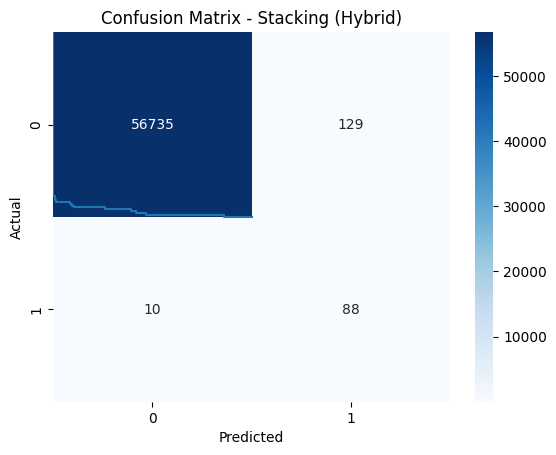

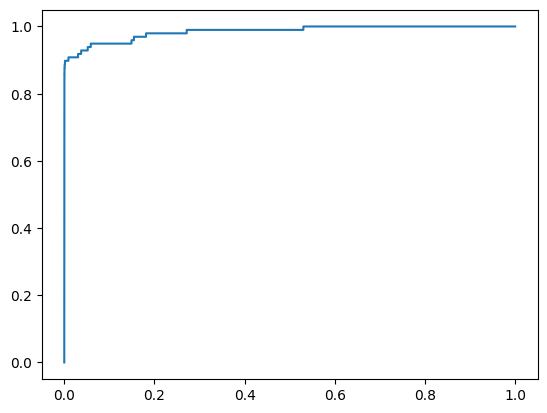

In [8]:
for name, model in models.items():
    print("\n===== Training:", name, "=====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.3f})")

C:\Users\DELL\AppData\Local\Temp\ipykernel_10596\3394011393.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


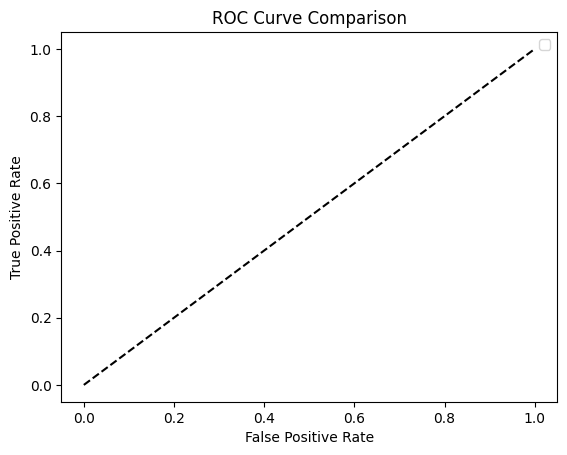

In [9]:
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [11]:
import joblib
import os

os.makedirs("models", exist_ok=True)

joblib.dump(voting_clf, "models/voting_model.pkl")
joblib.dump(stacking_clf, "models/stacking_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")
feature_names = X.columns.tolist() 
joblib.dump(feature_names, "models/feature_names.pkl")

print("✅ Models and scaler saved inside 'models/' folder.")

✅ Models and scaler saved inside 'models/' folder.
